<a href="https://colab.research.google.com/github/laguachara/EasyGerman/blob/main/An%C3%A1lisis_computacional_PM_alem%C3%A1n_oral_pipelinecompleto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experimento 1**

Este código implementa un sistema de clasificación automática de partículas modales en alemán (palabras como "ja", "auch", "aber", "mal", etc.) usando el algoritmo K-Nearest Neighbors (KNN). El objetivo es entrenar modelos que puedan identificar y clasificar estas partículas según su contexto.



**1. Carga de Datos**

Descarga automáticamente archivos .csv desde el repositorio de GitHub:
https://github.com/laguachara/EasyGerman_Corpus_csvdata

Consolida todos los textos en un DataFrame único

**2. Extracción de Contextos**

Usa spaCy (biblioteca de NLP) para procesar textos en alemán
Busca 15 partículas modales específicas definidas en PARTICULAS_MODALES
Para cada partícula encontrada, extrae características contextuales:

Palabra anterior y siguiente

Etiquetas gramaticales (POS tags)

Posición en la oración

Longitud de la oración


**3. Preparación para Machine Learning**

Filtra partículas que tienen suficientes muestras (≥10 por defecto)

Codifica características categóricas usando LabelEncoder

Crea un conjunto de datos estructurado para entrenamiento


**4. Entrenamiento de Modelos**

Entrena un clasificador KNN individual para cada partícula modal

Usa clasificación binaria (sí/no es esta partícula específica)

Aplica validación cruzada para evaluar rendimiento

Adapta el valor de "k" según el tamaño de los datos

**5. Evaluación y Visualización**

Calcula métricas: precisión, recall, F1-score

Genera gráficos de barras mostrando rendimiento por partícula

Produce una tabla resumen con todos los resultados



In [ ]:
!pip install pandas scikit-learn spacy matplotlib seaborn
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 59.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


=== ANÁLISIS KNN DE PARTÍCULAS MODALES ===
Implementación del experimento descrito en el TFM

1. Cargando corpus desde GitHub...
Encontrados 567 archivos CSV
Error cargando 100_Real_Life_Sentences_with_the_Verb_“haben”___Easy_German_589.vtt.de.csv: 'ascii' codec can't encode character '\u201c' in position 85: ordinal not in range(128)
Error cargando 102_Real_Life_Sentences_With_the_Verb_“Sein”___Easy_German_591.vtt.de.csv: 'ascii' codec can't encode character '\u201c' in position 85: ordinal not in range(128)
Procesados 10/567 archivos...
Error cargando 13_Swiss_Words_That_Germans_Don’t_Understand___Easy_German_538.vtt.de.csv: 'ascii' codec can't encode character '\u2019' in position 78: ordinal not in range(128)
Procesados 20/567 archivos...
Error cargando 70_Real_Life_Sentences_With_The_Verb_können___Easy_German_599.vtt.de.csv: 'ascii' codec can't encode character '\xf6' in position 85: ordinal not in range(128)
Procesados 30/567 archivos...
Error cargando 8_Things_You_Shouldn’t_Do_i

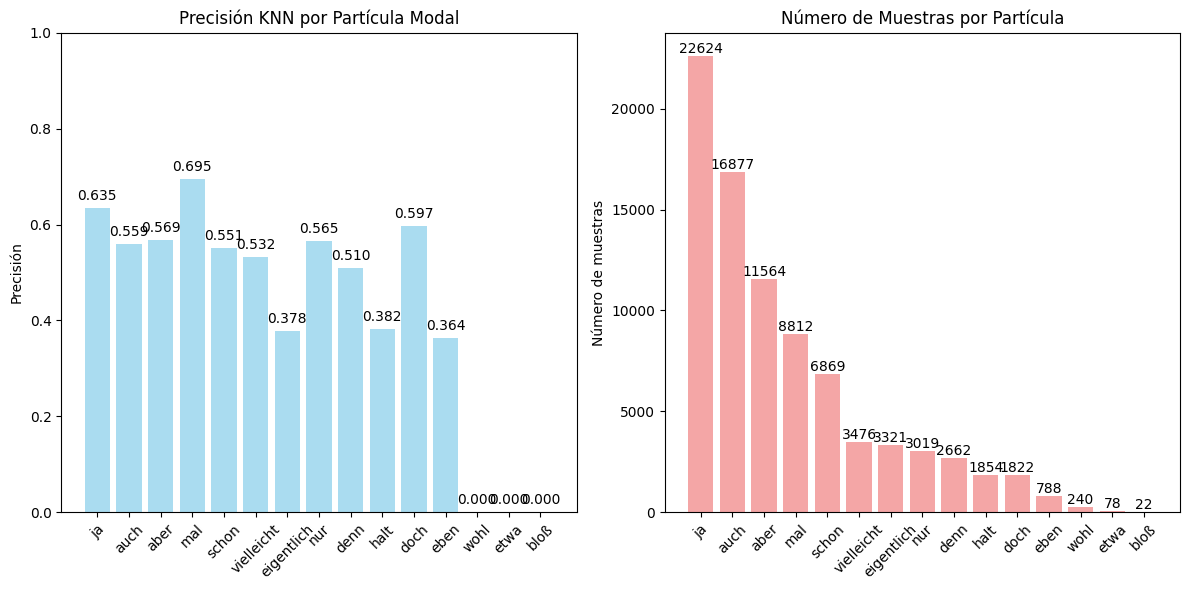


=== RESUMEN DE RESULTADOS ===
            precision  recall  f1_score  support
ja              0.635   0.493     0.555  22624.0
auch            0.559   0.378     0.451  16877.0
aber            0.569   0.333     0.420  11564.0
mal             0.695   0.483     0.570   8812.0
schon           0.551   0.245     0.339   6869.0
vielleicht      0.532   0.154     0.239   3476.0
eigentlich      0.378   0.110     0.170   3321.0
nur             0.565   0.215     0.312   3019.0
denn            0.510   0.145     0.225   2662.0
halt            0.382   0.078     0.130   1854.0
doch            0.597   0.118     0.197   1822.0
eben            0.364   0.025     0.047    788.0
wohl            0.000   0.000     0.000    240.0
etwa            0.000   0.000     0.000     78.0
bloß            0.000   0.000     0.000     22.0

=== ANÁLISIS COMPLETADO ===
Se analizaron 15 partículas modales
Precisión promedio: 0.422
F1-Score promedio: 0.244


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Carga el modelo de spaCy para alemán

try:
    nlp = spacy.load("de_core_news_sm")
except OSError:
    print("Modelo de alemán no encontrado. Ejecuta: python -m spacy download de_core_news_sm")
    exit()

# Lista de partículas modales a analizar
PARTICULAS_MODALES = [
    'ja', 'auch', 'aber', 'mal', 'schon', 'vielleicht',
    'nur', 'denn', 'eigentlich', 'doch', 'halt', 'eben',
    'wohl', 'etwa', 'bloß'
]

def cargar_corpus_desde_github():
    """
    Carga múltiples archivos CSV desde tu repositorio de GitHub
    """
    import requests

    # Obtención de la lista de archivos del repositorio
    api_url = "https://api.github.com/repos/laguachara/EasyGerman_Corpus_csvdata/contents"

    try:
        response = requests.get(api_url)
        if response.status_code != 200:
            print(f"Error accediendo al repositorio: {response.status_code}")
            return None

        archivos = response.json()
        archivos_csv = [arch for arch in archivos if arch['name'].endswith('.csv')]

        print(f"Encontrados {len(archivos_csv)} archivos CSV")

        # Cargar todos los archivos .csv disponibles
        archivos_a_cargar = archivos_csv

        todos_los_textos = []

        for i, archivo in enumerate(archivos_a_cargar):
            url = f"https://raw.githubusercontent.com/laguachara/EasyGerman_Corpus_csvdata/main/{archivo['name']}"

            try:
                df_temp = pd.read_csv(url)
                if 'text' in df_temp.columns:
                    textos = df_temp['text'].dropna().tolist()
                else:
                    textos = df_temp.iloc[:, 0].dropna().tolist()

                todos_los_textos.extend(textos)

                if (i + 1) % 10 == 0:
                    print(f"Procesados {i + 1}/{len(archivos_a_cargar)} archivos...")

            except Exception as e:
                print(f"Error cargando {archivo['name']}: {e}")
                continue

        # Creación del DataFrame final
        df_final = pd.DataFrame({'text': todos_los_textos})
        print(f"Corpus consolidado: {len(df_final)} líneas de texto")
        return df_final

    except Exception as e:
        print(f"Error general: {e}")
        return None

def extraer_contextos_particulas(textos):
    """
    Extrae contextos de partículas modales de los textos
    """
    contextos = []

    for texto in textos:
        if pd.isna(texto) or len(texto.strip()) < 10:
            continue

        # Preproceso con spaCy
        doc = nlp(texto.lower())
        tokens = [token.text for token in doc]
        pos_tags = [token.pos_ for token in doc]

        # Búsqueda de partículas modales
        for i, token in enumerate(tokens):
            if token in PARTICULAS_MODALES:
                # Extracción de características contextuales
                palabra_anterior = tokens[i-1] if i > 0 else "START"
                palabra_siguiente = tokens[i+1] if i < len(tokens)-1 else "END"
                pos_anterior = pos_tags[i-1] if i > 0 else "START"
                pos_siguiente = pos_tags[i+1] if i < len(pos_tags)-1 else "END"

                contexto = {
                    'particula': token,
                    'palabra_anterior': palabra_anterior,
                    'palabra_siguiente': palabra_siguiente,
                    'pos_anterior': pos_anterior,
                    'pos_siguiente': pos_siguiente,
                    'posicion': i,
                    'longitud_oracion': len(tokens),
                    'texto_completo': texto
                }
                contextos.append(contexto)

    return pd.DataFrame(contextos)

def preparar_datos_ml(df_contextos, min_samples=10):
    """
    Prepara los datos para machine learning
    """
    # Filtrar partículas con suficientes muestras
    conteos = df_contextos['particula'].value_counts()
    particulas_validas = conteos[conteos >= min_samples].index.tolist()

    print(f"\nDistribución de partículas modales:")
    print(conteos)
    print(f"\nPartículas con ≥{min_samples} muestras para ML: {particulas_validas}")

    df_filtrado = df_contextos[df_contextos['particula'].isin(particulas_validas)]

    # Codificar características categóricas
    le_palabra_ant = LabelEncoder()
    le_palabra_sig = LabelEncoder()
    le_pos_ant = LabelEncoder()
    le_pos_sig = LabelEncoder()

    # Preparar características (X)
    X = pd.DataFrame({
        'palabra_anterior_encoded': le_palabra_ant.fit_transform(df_filtrado['palabra_anterior']),
        'palabra_siguiente_encoded': le_palabra_sig.fit_transform(df_filtrado['palabra_siguiente']),
        'pos_anterior_encoded': le_pos_ant.fit_transform(df_filtrado['pos_anterior']),
        'pos_siguiente_encoded': le_pos_sig.fit_transform(df_filtrado['pos_siguiente']),
        'posicion': df_filtrado['posicion'],
        'longitud_oracion': df_filtrado['longitud_oracion']
    })

    # Variable objetivo (y)
    y = df_filtrado['particula']

    return X, y, df_filtrado, particulas_validas

def entrenar_modelos_knn(X, y, particulas_validas):
    """
    Entrena modelos KNN individuales para cada partícula modal
    """
    resultados = {}

    for particula in particulas_validas:
        print(f"\n--- Analizando partícula: {particula} ---")

        # Crear etiquetas binarias para esta partícula específica
        y_binary = (y == particula).astype(int)

        # División train/test estratificada
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
        )

        # Configurar KNN con k adaptativo
        n_samples = len(X_train)
        k = min(5, max(3, n_samples // 4))  # k adaptativo

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        # Predicciones
        y_pred = knn.predict(X_test)

        # Validación cruzada
        cv_scores = cross_val_score(knn, X_train, y_train, cv=min(5, n_samples//2))

        # Métricas de evaluación implementadas
        from sklearn.metrics import precision_score, recall_score, f1_score

        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        resultados[particula] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'support': sum(y_binary),
            'k_usado': k
        }

        print(f"Precisión: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-Score: {f1:.3f}")
        print(f"CV Score: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
        print(f"Soporte: {sum(y_binary)} muestras")

    return resultados

def visualizar_resultados(resultados):
    """
    Crea visualizaciones de los resultados
    """
    # Preparar datos para visualización
    particulas = list(resultados.keys())
    precision_scores = [resultados[p]['precision'] for p in particulas]
    f1_scores = [resultados[p]['f1_score'] for p in particulas]
    support = [resultados[p]['support'] for p in particulas]

    # Gráfico 1: Precisión por partícula
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    bars = plt.bar(particulas, precision_scores, color='skyblue', alpha=0.7)
    plt.title('Precisión KNN por Partícula Modal')
    plt.ylabel('Precisión')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Añadir valores en las barras
    for bar, score in zip(bars, precision_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    # Gráfico 2: Soporte (número de muestras)
    plt.subplot(1, 2, 2)
    bars2 = plt.bar(particulas, support, color='lightcoral', alpha=0.7)
    plt.title('Número de Muestras por Partícula')
    plt.ylabel('Número de muestras')
    plt.xticks(rotation=45)

    for bar, count in zip(bars2, support):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Tabla resumen
    df_resultados = pd.DataFrame(resultados).T
    df_resultados = df_resultados.round(3)
    print("\n=== RESUMEN DE RESULTADOS ===")
    print(df_resultados[['precision', 'recall', 'f1_score', 'support']])

    return df_resultados

def main():
    """
    Función principal que ejecuta todo el análisis
    """
    print("=== ANÁLISIS KNN DE PARTÍCULAS MODALES ===")
    print("Implementación del experimento descrito en el TFM\n")

    # 1. Cargar datos
    print("1. Cargando corpus desde GitHub...")
    df = cargar_corpus_desde_github()
    if df is None:
        return

    # 2. Extraer contextos
    print("2. Extrayendo contextos de partículas modales...")
    df_contextos = extraer_contextos_particulas(df['text'] if 'text' in df.columns else df.iloc[:, 0])
    print(f"   Contextos extraídos: {len(df_contextos)}")

    if len(df_contextos) == 0:
        print("No se encontraron partículas modales en el corpus.")
        return

    # 3. Preparar datos para ML
    print("3. Preparando datos para machine learning...")
    X, y, df_filtrado, particulas_validas = preparar_datos_ml(df_contextos)

    if len(particulas_validas) == 0:
        print("No hay suficientes datos para entrenar modelos.")
        return

    # 4. Entrenar modelos KNN
    print("4. Entrenando clasificadores KNN...")
    resultados = entrenar_modelos_knn(X, y, particulas_validas)

    # 5. Visualizar resultados
    print("5. Generando visualizaciones...")
    df_resultados = visualizar_resultados(resultados)

    print("\n=== ANÁLISIS COMPLETADO ===")
    print(f"Se analizaron {len(particulas_validas)} partículas modales")
    print(f"Precisión promedio: {df_resultados['precision'].mean():.3f}")
    print(f"F1-Score promedio: {df_resultados['f1_score'].mean():.3f}")

    return df_contextos, resultados, df_resultados

# Ejecutar el análisis
if __name__ == "__main__":
    contextos, resultados_por_particula, resultados_globales = main()

# **Presentación y análisis de resultados.**

Este código visualiza y analiza los resultados obtenidos del experimento KNN de partículas modales alemanas.

**1. Datos de Entrada**

Usa resultados pre-calculados del experimento anterior

15 partículas modales con sus métricas de rendimiento

Datos incluyen: precisión, recall, F1-score y número de muestras


**2. Visualizaciones (4 gráficos principales)**

Gráfico 1: Precisión por partícula (barras azules)

Gráfico 2: F1-Score por partícula (barras verdes)

Gráfico 3: Comparación lado a lado de Precisión vs Recall

Gráfico 4: Número de muestras por partícula


**3. Gráfico de Resumen**

Métricas promedio generales del clasificador

Solo considera partículas que tienen datos válidos (>0)

**4. Análisis Estadístico**

Tabla ordenada por F1-Score (de mejor a peor rendimiento)

Estadísticas generales del experimento

Identificación de la mejor partícula clasificada



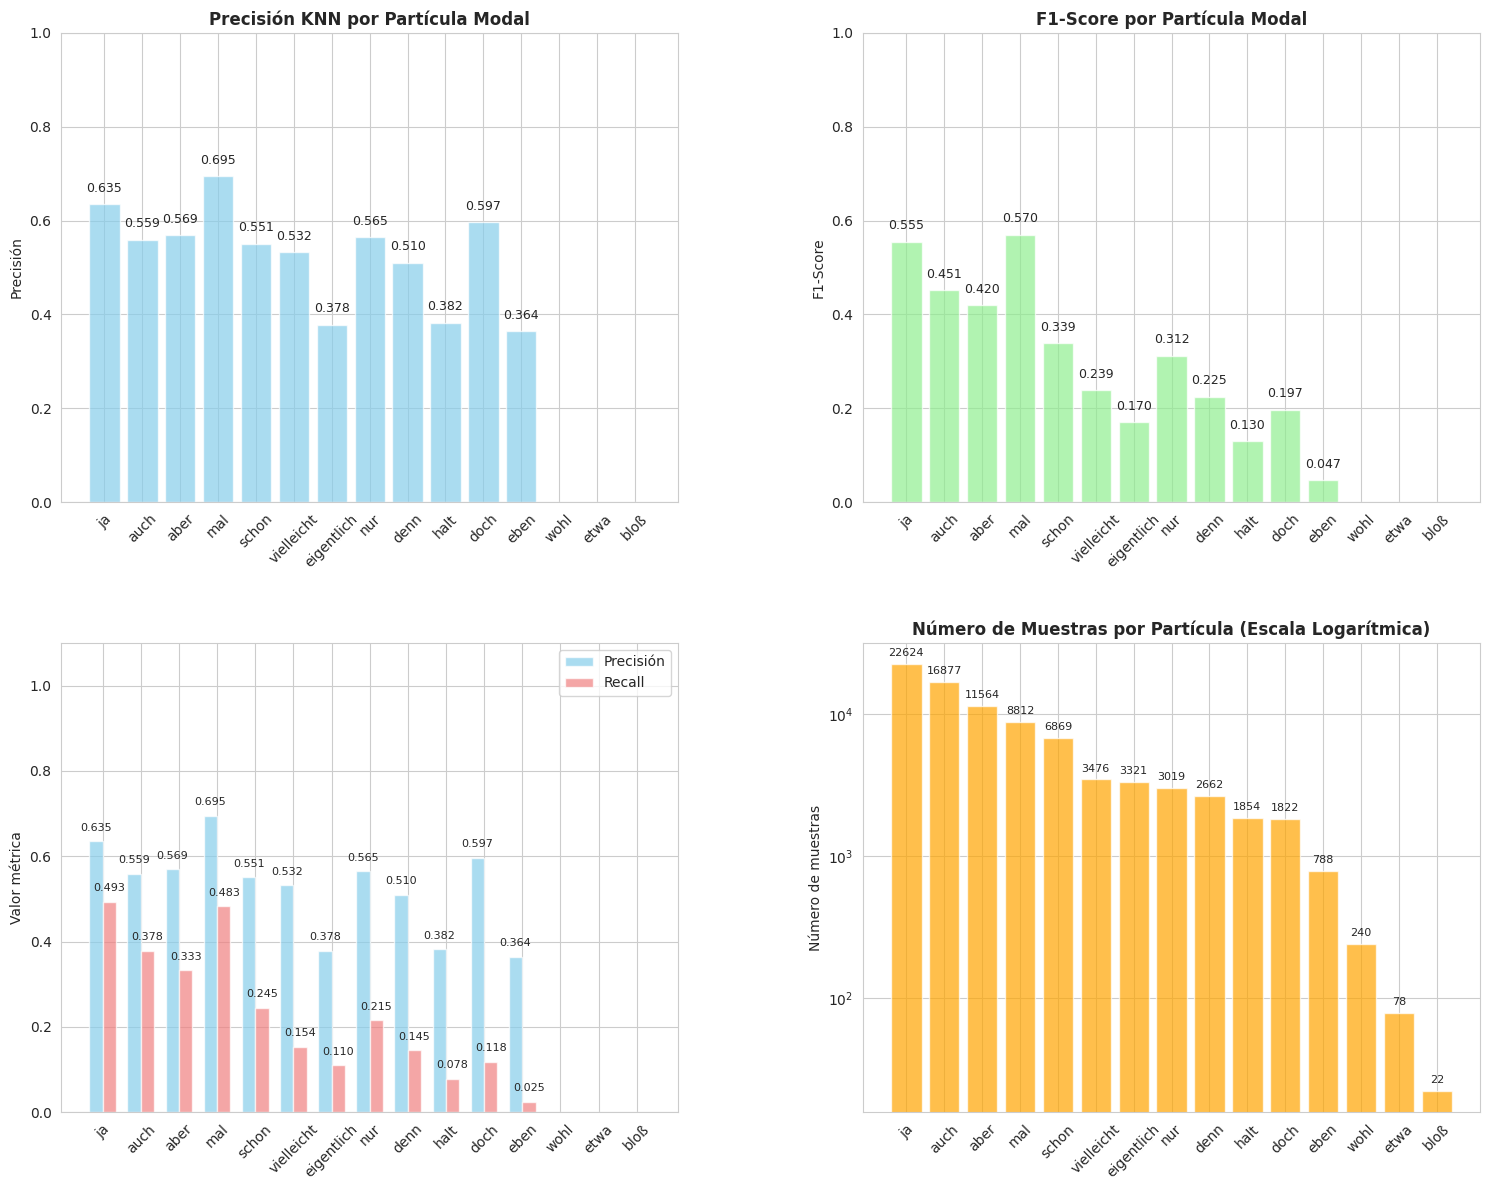

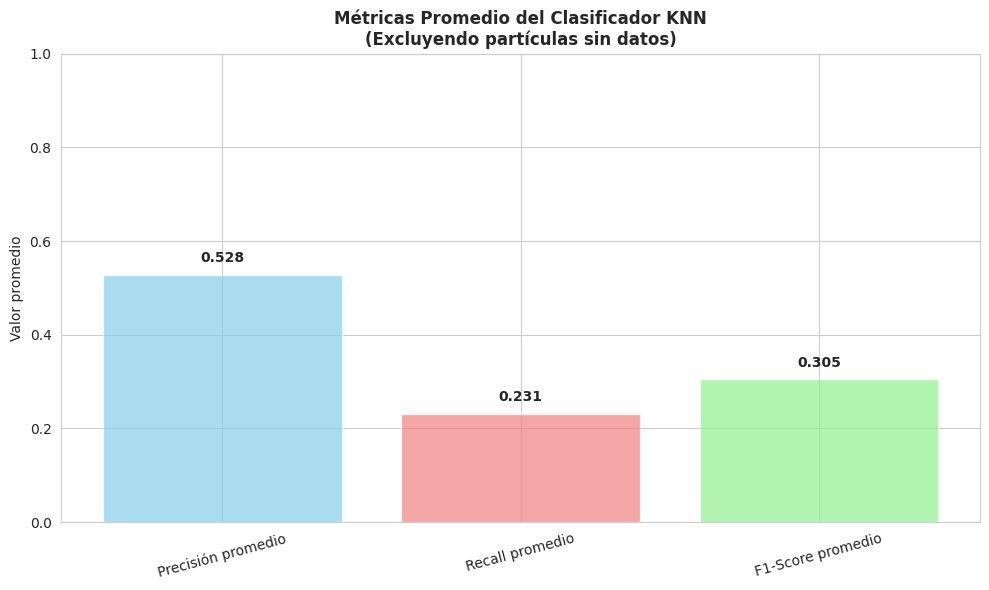

=== TABLA RESUMEN ORDENADA POR F1-SCORE ===
     particula  precision  recall  f1_score  support
3          mal      0.695   0.483     0.570     8812
0           ja      0.635   0.493     0.555    22624
1         auch      0.559   0.378     0.451    16877
2         aber      0.569   0.333     0.420    11564
4        schon      0.551   0.245     0.339     6869
7          nur      0.565   0.215     0.312     3019
5   vielleicht      0.532   0.154     0.239     3476
8         denn      0.510   0.145     0.225     2662
10        doch      0.597   0.118     0.197     1822
6   eigentlich      0.378   0.110     0.170     3321
9         halt      0.382   0.078     0.130     1854
11        eben      0.364   0.025     0.047      788
12        wohl      0.000   0.000     0.000      240
13        etwa      0.000   0.000     0.000       78
14        bloß      0.000   0.000     0.000       22

=== ESTADÍSTICAS GENERALES ===
Partículas analizadas: 15
Partículas con rendimiento > 0: 12
Precisión prome

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Datos de los resultados del experimento 1
datos_resultados = {
    'particula': ['ja', 'auch', 'aber', 'mal', 'schon', 'vielleicht',
                  'eigentlich', 'nur', 'denn', 'halt', 'doch', 'eben',
                  'wohl', 'etwa', 'bloß'],
    'precision': [0.635, 0.559, 0.569, 0.695, 0.551, 0.532,
                  0.378, 0.565, 0.510, 0.382, 0.597, 0.364,
                  0.000, 0.000, 0.000],
    'recall': [0.493, 0.378, 0.333, 0.483, 0.245, 0.154,
               0.110, 0.215, 0.145, 0.078, 0.118, 0.025,
               0.000, 0.000, 0.000],
    'f1_score': [0.555, 0.451, 0.420, 0.570, 0.339, 0.239,
                 0.170, 0.312, 0.225, 0.130, 0.197, 0.047,
                 0.000, 0.000, 0.000],
    'support': [22624, 16877, 11564, 8812, 6869, 3476,
                3321, 3019, 2662, 1854, 1822, 788,
                240, 78, 22]
}

df_resultados = pd.DataFrame(datos_resultados)

# Configuración general para las gráficas
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = [15, 10]

# Crear figura con 4 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Colores para consistencia visual
color_precision = 'skyblue'
color_recall = 'lightcoral'
color_f1 = 'lightgreen'
color_support = 'orange'

# Gráfico 1: Precisión por partícula
bars1 = ax1.bar(df_resultados['particula'], df_resultados['precision'],
                color=color_precision, alpha=0.7)
ax1.set_title('Precisión KNN por Partícula Modal', fontsize=12, fontweight='bold')
ax1.set_ylabel('Precisión')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# Añadir valores en las barras
for bar, score in zip(bars1, df_resultados['precision']):
    if score > 0:  # Solo mostrar valores mayores a 0 para legibilidad
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: F1-Score por partícula
bars2 = ax2.bar(df_resultados['particula'], df_resultados['f1_score'],
                color=color_f1, alpha=0.7)
ax2.set_title('F1-Score por Partícula Modal', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)

for bar, score in zip(bars2, df_resultados['f1_score']):
    if score > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# Gráfico 3: Comparación Precisión vs recall con valores en barras
x = np.arange(len(df_resultados['particula']))
width = 0.35

bars3a = ax3.bar(x - width/2, df_resultados['precision'], width,
                 label='Precisión', color=color_precision, alpha=0.7)
bars3b = ax3.bar(x + width/2, df_resultados['recall'], width,
                 label='Recall', color=color_recall, alpha=0.7)

ax3.set_title('', fontsize=12, fontweight='bold')
ax3.set_ylabel('Valor métrica')
ax3.set_ylim(0, 1.1)
ax3.set_xticks(x)
ax3.set_xticklabels(df_resultados['particula'], rotation=45)
ax3.legend()

# Añadir valores en las barras de precisión
for i, (bar, score) in enumerate(zip(bars3a, df_resultados['precision'])):
    if score > 0:
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# Añadir valores en las barras de recall
for i, (bar, score) in enumerate(zip(bars3b, df_resultados['recall'])):
    if score > 0:
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# Gráfico 4: Número de muestras
bars4 = ax4.bar(df_resultados['particula'], df_resultados['support'],
                color=color_support, alpha=0.7)
ax4.set_title('Número de Muestras por Partícula (Escala Logarítmica)',
              fontsize=12, fontweight='bold')
ax4.set_ylabel('Número de muestras')
ax4.set_yscale('log')  # Escala logarítmica para mejor visualización
ax4.tick_params(axis='x', rotation=45)

# Añadir valores en las barras del support
for bar, count in zip(bars4, df_resultados['support']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
            str(count), ha='center', va='bottom', fontsize=8)

# Ajustar espaciado
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Mostrar gráfica
plt.show()

# Crear también una gráfica de resumen con métricas promedio
plt.figure(figsize=(10, 6))

# Calcular promedios para partículas con datos (excluyendo las que tienen 0)
particulas_con_datos = df_resultados[df_resultados['precision'] > 0]
promedios = {
    'Precisión promedio': particulas_con_datos['precision'].mean(),
    'Recall promedio': particulas_con_datos['recall'].mean(),
    'F1-Score promedio': particulas_con_datos['f1_score'].mean()
}

# Gráfico de barras de resumen
plt.bar(promedios.keys(), promedios.values(),
        color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
plt.title('Métricas Promedio del Clasificador KNN\n(Excluyendo partículas sin datos)',
          fontsize=12, fontweight='bold')
plt.ylabel('Valor promedio')
plt.ylim(0, 1)

# Añadir valores en las barras
for i, (metrica, valor) in enumerate(promedios.items()):
    plt.text(i, valor + 0.02, f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Mostrar tabla resumen ordenada por F1-Score
print("=== TABLA RESUMEN ORDENADA POR F1-SCORE ===")
df_ordenado = df_resultados.sort_values('f1_score', ascending=False)
print(df_ordenado[['particula', 'precision', 'recall', 'f1_score', 'support']])

print(f"\n=== ESTADÍSTICAS GENERALES ===")
print(f"Partículas analizadas: {len(df_resultados)}")
print(f"Partículas con rendimiento > 0: {len(particulas_con_datos)}")
print(f"Precisión promedio (excluyendo ceros): {particulas_con_datos['precision'].mean():.3f}")
print(f"F1-Score promedio (excluyendo ceros): {particulas_con_datos['f1_score'].mean():.3f}")
print(f"Mejor F1-Score: {df_resultados['f1_score'].max():.3f} ({df_resultados.loc[df_resultados['f1_score'].idxmax(), 'particula']})")
print(f"Total de muestras procesadas: {df_resultados['support'].sum()}")

# Experimento 2


Este experimento evalúa si los sistemas de traducción automática (Google Translate) pueden mantener la función comunicativa de las partículas modales cuando traducen textos del alemán al español.

**1. Preparación de Equivalencias**

Define un diccionario EQUIVALENCIAS_ESPANOL con traducciones válidas para cada partícula.


**2. Extracción de Oraciones con Partículas**

Encuentra oraciones del corpus que contengan partículas modales.

Registra qué partículas aparecen en cada oración.

**3. Traducción Automática**

Usa la API de Google Translate para traducir las oraciones al español:
Muestra limitada: Usa máximo 500 oraciones aleatorias para evitar problemas con límites de Google Translate API.

Implementa pausas para evitar límites de API.

Maneja errores de traducción.


**4. Evaluación de Preservación**

Clave del experimento: Verifica si las traducciones al español contienen equivalentes válidos.

Para cada partícula original, busca si aparece alguna de sus equivalencias en español.

Marca como "preservada" o "perdida".


**5. Análisis de Resultados**

Calcula la tasa de preservación global y por partícula.

Identifica qué partículas se traducen mejor/peor.

Analiza la relación entre frecuencia y preservación.


**6. Visualizaciones (4 gráficos)**

Tasa de preservación por partícula.

Frecuencia de aparición.

catter plot frecuencia vs preservación.

Distribución global (preservadas vs perdidas).




In [ ]:
!pip install googletrans==4.0.0rc1

=== EXPERIMENTO 2: EVALUACIÓN DE TRADUCCIÓN AUTOMÁTICA ===
Evaluación de Google Translate en partículas modales alemanas

1. Cargando corpus desde GitHub...
Encontrados 567 archivos CSV
Procesados 50/567 archivos...
Procesados 100/567 archivos...
Procesados 150/567 archivos...
Procesados 200/567 archivos...
Procesados 250/567 archivos...
Procesados 300/567 archivos...
Procesados 350/567 archivos...
Procesados 400/567 archivos...
Procesados 450/567 archivos...
Procesados 500/567 archivos...
Procesados 550/567 archivos...
Corpus consolidado: 380433 líneas de texto
2. Extrayendo oraciones con partículas modales...
   Oraciones con partículas modales: 68071
   Limitando análisis a 500 oraciones aleatorias
3. Traduciendo oraciones con Google Translate...
Iniciando traducción de 500 oraciones...
Traducidas 21670/500 oraciones...
Traducidas 29200/500 oraciones...
Traducidas 55370/500 oraciones...
Traducidas 31700/500 oraciones...
Traducidas 54270/500 oraciones...
Traducidas 25055/500 oracione

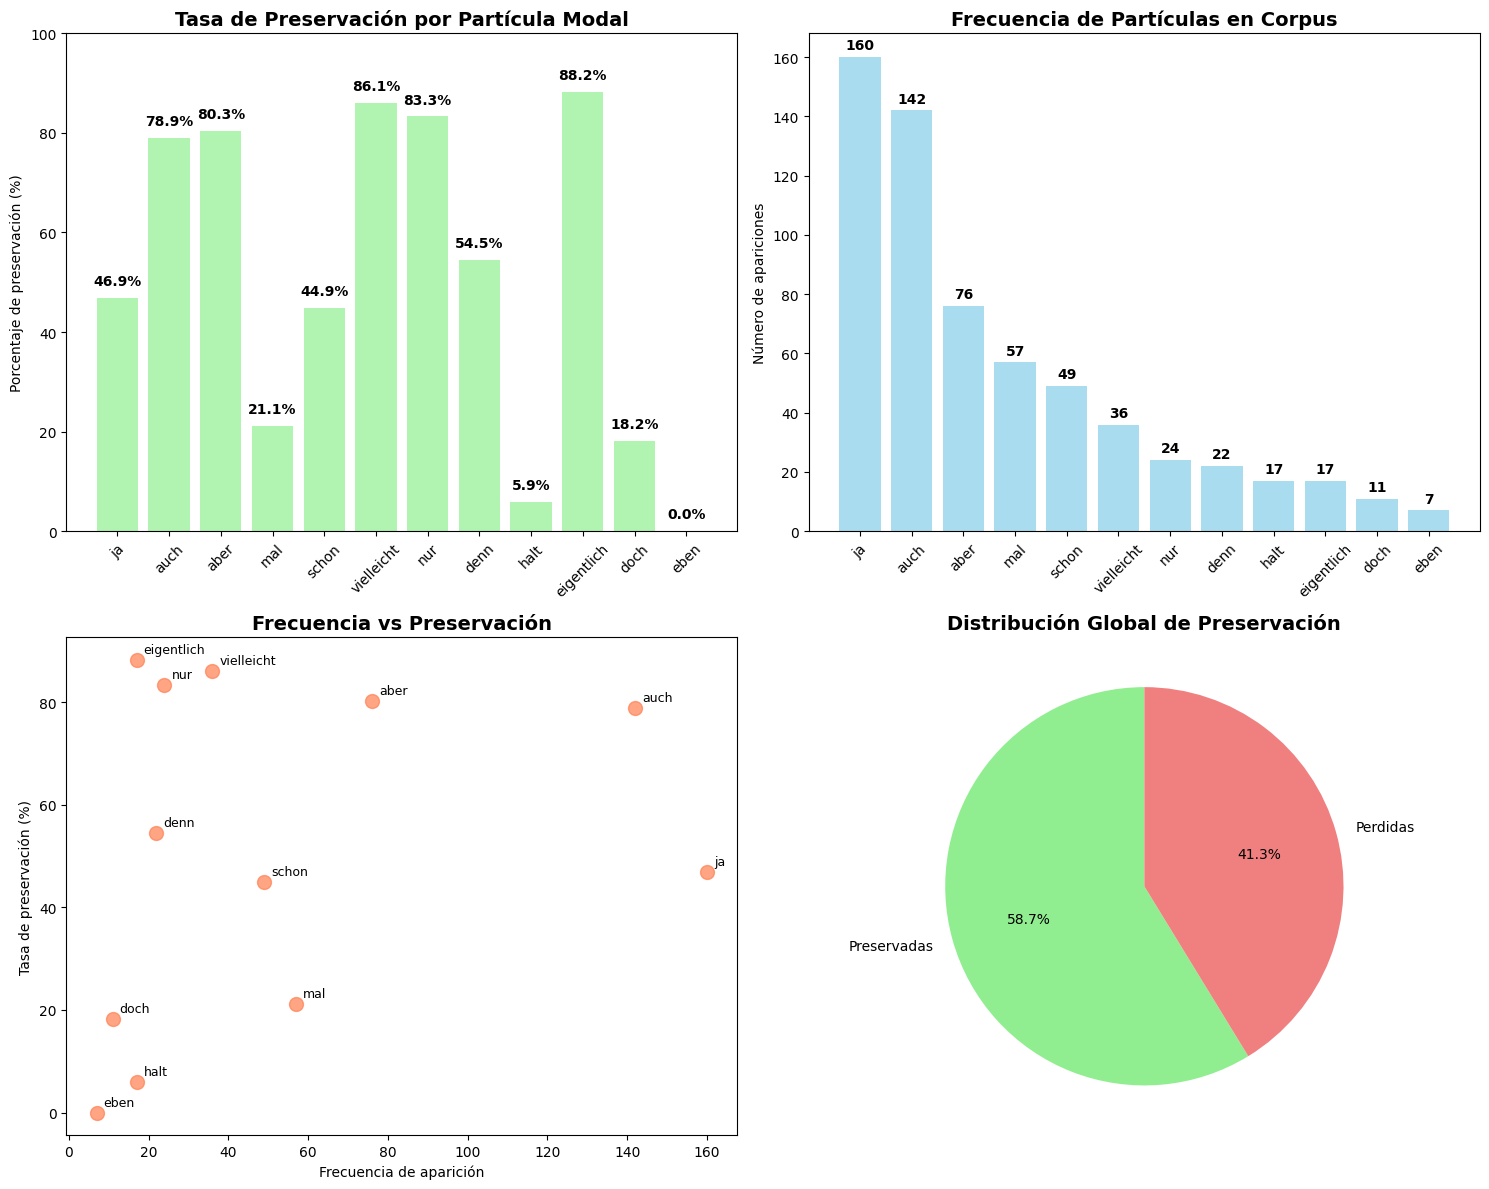


=== EXPERIMENTO 2 COMPLETADO ===
Tasa de preservación global: 58.7%
Partículas mejor preservadas: ['ja', 'auch', 'aber']
Partículas peor preservadas: ['eigentlich', 'doch', 'eben']


In [ ]:
import pandas as pd
import numpy as np
import re
import time
from googletrans import Translator
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# Cargar el modelo de spaCy para alemán
try:
    nlp = spacy.load("de_core_news_sm")
except OSError:
    print("Modelo de alemán no encontrado. Ejecuta: python -m spacy download de_core_news_sm")
    exit()

# Lista de partículas modales a analizar
PARTICULAS_MODALES = [
    'ja', 'auch', 'aber', 'mal', 'schon', 'vielleicht',
    'nur', 'denn', 'eigentlich', 'doch', 'halt', 'eben',
    'wohl', 'etwa', 'bloß'
]

# Diccionario de equivalencias válidas en español
EQUIVALENCIAS_ESPANOL = {
    'ja': ['sí', 'pues', 'vaya', 'sí que', 'ya', 'claro', 'desde luego'],
    'auch': ['también', 'tampoco', 'asimismo', 'incluso', 'además'],
    'aber': ['pero', 'sin embargo', 'mas', 'aunque'],
    'mal': ['vez', 'una vez', 'momento', 'anda', 'vamos', 'pues'],
    'schon': ['ya', 'bien', 'desde luego', 'efectivamente', 'ciertamente'],
    'vielleicht': ['quizás', 'tal vez', 'acaso', 'puede que', 'a lo mejor'],
    'nur': ['solo', 'sólo', 'únicamente', 'solamente', 'tan solo'],
    'denn': ['pues', 'porque', 'entonces', 'ya que'],
    'eigentlich': ['realmente', 'en realidad', 'en el fondo', 'de hecho', 'propiamente'],
    'doch': ['pero', 'sí que', 'desde luego', 'sin embargo', 'no obstante'],
    'halt': ['pues', 'bueno', 'así', 'simplemente'],
    'eben': ['precisamente', 'exactamente', 'justamente', 'pues'],
    'wohl': ['probablemente', 'seguramente', 'supongo', 'creo'],
    'etwa': ['aproximadamente', 'más o menos', 'unos', 'cerca de', 'acaso'],
    'bloß': ['solo', 'sólo', 'únicamente', 'tan solo', 'simplemente']
}

def cargar_corpus_desde_github():
    """
    Carga múltiples archivos CSV desde el repositorio de GitHub
    """
    api_url = "https://api.github.com/repos/laguachara/EasyGerman_Corpus_csvdata/contents"

    try:
        response = requests.get(api_url)
        if response.status_code != 200:
            print(f"Error accediendo al repositorio: {response.status_code}")
            return None

        archivos = response.json()
        archivos_csv = [arch for arch in archivos if arch['name'].endswith('.csv')]

        print(f"Encontrados {len(archivos_csv)} archivos CSV")

        # Cargar todos los archivos .csv
        todos_los_textos = []

        for i, archivo in enumerate(archivos_csv):
            url = f"https://raw.githubusercontent.com/laguachara/EasyGerman_Corpus_csvdata/main/{archivo['name']}"

            try:
                df_temp = pd.read_csv(url)
                if 'text' in df_temp.columns:
                    textos = df_temp['text'].dropna().tolist()
                else:
                    textos = df_temp.iloc[:, 0].dropna().tolist()

                todos_los_textos.extend(textos)

                if (i + 1) % 50 == 0:
                    print(f"Procesados {i + 1}/{len(archivos_csv)} archivos...")

            except Exception as e:
                continue
        df_final = pd.DataFrame({'text': todos_los_textos})
        print(f"Corpus consolidado: {len(df_final)} líneas de texto")
        return df_final

    except Exception as e:
        print(f"Error general: {e}")
        return None

def extraer_oraciones_con_particulas(textos):
    """
    Extrae oraciones que contienen partículas modales
    """
    oraciones_con_particulas = []

    for texto in textos:
        if pd.isna(texto) or len(texto.strip()) < 10:
            continue

        # Procesar con spaCy
        doc = nlp(texto.lower())
        tokens = [token.text for token in doc]

        # Verificar si contiene partículas modales
        particulas_encontradas = []
        for token in tokens:
            if token in PARTICULAS_MODALES:
                particulas_encontradas.append(token)

        if particulas_encontradas:
            oraciones_con_particulas.append({
                'texto_original': texto,
                'particulas': particulas_encontradas,
                'num_particulas': len(particulas_encontradas)
            })

    return pd.DataFrame(oraciones_con_particulas)

def traducir_oraciones(df_oraciones, batch_size=5):
    """
    Traduce las oraciones al español usando Google Translate
    """
    translator = Translator()
    resultados = []

    print(f"Iniciando traducción de {len(df_oraciones)} oraciones...")

    for i, row in df_oraciones.iterrows():
        try:
            # Traducir al español
            traduccion = translator.translate(row['texto_original'], src='de', dest='es')

            resultado = {
                'texto_original': row['texto_original'],
                'texto_traducido': traduccion.text,
                'particulas_originales': row['particulas'],
                'num_particulas': row['num_particulas']
            }
            resultados.append(resultado)

            # Pausa cada batch_size traducciones para evitar límites de API
            if (i + 1) % batch_size == 0:
                time.sleep(1)
                print(f"Traducidas {i + 1}/{len(df_oraciones)} oraciones...")

        except Exception as e:
            # En caso de error, registrar como fallo
            resultado = {
                'texto_original': row['texto_original'],
                'texto_traducido': 'ERROR_TRANSLATION',
                'particulas_originales': row['particulas'],
                'num_particulas': row['num_particulas']
            }
            resultados.append(resultado)
            print(f"Error traduciendo oración {i+1}: {e}")

    return pd.DataFrame(resultados)

def evaluar_preservacion(df_traducciones):
    """
    Evalúa si las partículas modales se preservaron en la traducción
    """
    resultados_preservacion = []

    for _, row in df_traducciones.iterrows():
        if row['texto_traducido'] == 'ERROR_TRANSLATION':
            continue

        texto_traducido = row['texto_traducido'].lower()

        for particula in row['particulas_originales']:
            # Buscar equivalencias en el texto traducido
            equivalencias = EQUIVALENCIAS_ESPANOL.get(particula, [])
            preservada = False

            for equivalencia in equivalencias:
                if equivalencia.lower() in texto_traducido:
                    preservada = True
                    break

            resultados_preservacion.append({
                'texto_original': row['texto_original'],
                'texto_traducido': row['texto_traducido'],
                'particula': particula,
                'preservada': preservada,
                'equivalencias_buscadas': equivalencias
            })

    return pd.DataFrame(resultados_preservacion)

def analizar_resultados_preservacion(df_preservacion):
    """
    Analiza los resultados de preservación de partículas modales
    """
    print("\n" + "="*80)
    print("ANÁLISIS DE PRESERVACIÓN DE PARTÍCULAS MODALES")
    print("="*80)

    # Estadísticas globales
    total_particulas = len(df_preservacion)
    particulas_preservadas = df_preservacion['preservada'].sum()
    tasa_preservacion_global = (particulas_preservadas / total_particulas) * 100

    print(f"Total de partículas analizadas: {total_particulas}")
    print(f"Partículas preservadas: {particulas_preservadas}")
    print(f"Tasa de preservación global: {tasa_preservacion_global:.1f}%")

    # Análisis por partícula
    print(f"\n--- PRESERVACIÓN POR PARTÍCULA ---")
    preservacion_por_particula = df_preservacion.groupby('particula').agg({
        'preservada': ['count', 'sum', 'mean']
    }).round(3)

    preservacion_por_particula.columns = ['total', 'preservadas', 'tasa_preservacion']
    preservacion_por_particula['porcentaje'] = (preservacion_por_particula['tasa_preservacion'] * 100).round(1)

    # Ordenar por frecuencia
    preservacion_por_particula = preservacion_por_particula.sort_values('total', ascending=False)

    for particula, datos in preservacion_por_particula.iterrows():
        print(f"{particula:>12}: {datos['preservadas']:>4.0f}/{datos['total']:>4.0f} ({datos['porcentaje']:>5.1f}%)")

    return preservacion_por_particula, tasa_preservacion_global

def visualizar_preservacion(preservacion_por_particula):
    """
    Crea visualizaciones de los resultados de preservación
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Preparar datos
    particulas = preservacion_por_particula.index.tolist()
    porcentajes = preservacion_por_particula['porcentaje'].tolist()
    totales = preservacion_por_particula['total'].tolist()
    preservadas = preservacion_por_particula['preservadas'].tolist()

    # Gráfico 1: Tasa de preservación por partícula
    bars1 = ax1.bar(particulas, porcentajes, color='lightgreen', alpha=0.7)
    ax1.set_title('Tasa de Preservación por Partícula Modal', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Porcentaje de preservación (%)')
    ax1.set_ylim(0, 100)
    ax1.tick_params(axis='x', rotation=45)

    for bar, pct in zip(bars1, porcentajes):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Gráfico 2: Frecuencia de aparición
    bars2 = ax2.bar(particulas, totales, color='skyblue', alpha=0.7)
    ax2.set_title('Frecuencia de Partículas en Corpus', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Número de apariciones')
    ax2.tick_params(axis='x', rotation=45)

    for bar, total in zip(bars2, totales):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(totales)*0.01,
                str(int(total)), ha='center', va='bottom', fontweight='bold')

    # Gráfico 3: Relación frecuencia vs preservación
    ax3.scatter(totales, porcentajes, alpha=0.7, s=100, color='coral')
    ax3.set_xlabel('Frecuencia de aparición')
    ax3.set_ylabel('Tasa de preservación (%)')
    ax3.set_title('Frecuencia vs Preservación', fontsize=14, fontweight='bold')

    # Añadir etiquetas de partículas
    for i, particula in enumerate(particulas):
        ax3.annotate(particula, (totales[i], porcentajes[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

    # Gráfico 4: Partículas preservadas vs perdidas
    categorias = ['Preservadas', 'Perdidas']
    total_preservadas = sum(preservadas)
    total_perdidas = sum(totales) - total_preservadas
    valores = [total_preservadas, total_perdidas]

    ax4.pie(valores, labels=categorias, autopct='%1.1f%%', startangle=90,
            colors=['lightgreen', 'lightcoral'])
    ax4.set_title('Distribución Global de Preservación', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

def main():
    """
    Función principal del Experimento 2: Evaluación de Traducción Automática
    """
    print("=== EXPERIMENTO 2: EVALUACIÓN DE TRADUCCIÓN AUTOMÁTICA ===")
    print("Evaluación de Google Translate en partículas modales alemanas\n")

    # 1. Cargar corpus
    print("1. Cargando corpus desde GitHub...")
    df = cargar_corpus_desde_github()
    if df is None:
        return

    # 2. Extracción de oraciones con partículas modales
    print("2. Extrayendo oraciones con partículas modales...")
    df_oraciones = extraer_oraciones_con_particulas(df['text'])
    print(f"   Oraciones con partículas modales: {len(df_oraciones)}")

    if len(df_oraciones) == 0:
        print("No se encontraron oraciones con partículas modales.")
        return

    # Limitar a una muestra manejable para evitar límites de API
    max_oraciones = 500
    if len(df_oraciones) > max_oraciones:
        df_oraciones = df_oraciones.sample(n=max_oraciones, random_state=42)
        print(f"   Limitando análisis a {max_oraciones} oraciones aleatorias")

    # 3. Traducir oraciones
    print("3. Traduciendo oraciones con Google Translate...")
    df_traducciones = traducir_oraciones(df_oraciones)

    # 4. Evaluar preservación
    print("4. Evaluando preservación de partículas modales...")
    df_preservacion = evaluar_preservacion(df_traducciones)

    if len(df_preservacion) == 0:
        print("No hay datos de preservación para analizar.")
        return

    # 5. Analizar resultados
    print("5. Analizando resultados...")
    preservacion_por_particula, tasa_global = analizar_resultados_preservacion(df_preservacion)

    # 6. Visualizar resultados
    print("6. Generando visualizaciones...")
    visualizar_preservacion(preservacion_por_particula)

    print(f"\n=== EXPERIMENTO 2 COMPLETADO ===")
    print(f"Tasa de preservación global: {tasa_global:.1f}%")
    print(f"Partículas mejor preservadas: {preservacion_por_particula.head(3).index.tolist()}")
    print(f"Partículas peor preservadas: {preservacion_por_particula.tail(3).index.tolist()}")

    return df_preservacion, preservacion_por_particula, tasa_global

if __name__ == "__main__":
    preservacion, por_particula, tasa_global = main()


**Script de análisis temático específico**

Investiga si existe correlación entre qué tan frecuente es una partícula modal y qué tan bien la preserva Google Translate, desafiando la hipótesis intuitiva de que "más frecuente = mejor traducido".

**1. Análisis de Correlación Frecuencia-Preservación**

Incorpora una clasificación adicional por tipo de equivalencias:

Claras: Tienen equivalentes directos en español

Variables: Equivalencias contextualmente dependientes

Problemáticas: Sin equivalencias claras




**2. Visualización Narrativa Avanzada**

Scatter plot principal con anotaciones detalladas de casos destacados

Línea de tendencia para mostrar correlación débil

Colores semánticos según tipo de equivalencias

Texto explicativo integrado en el gráfico

**3. Dos Gráficos Complementarios**

Comparación directa de casos contrastantes (ja vs eigentlich)

Análisis por cuadrantes dividiendo en 4 categorías de rendimiento



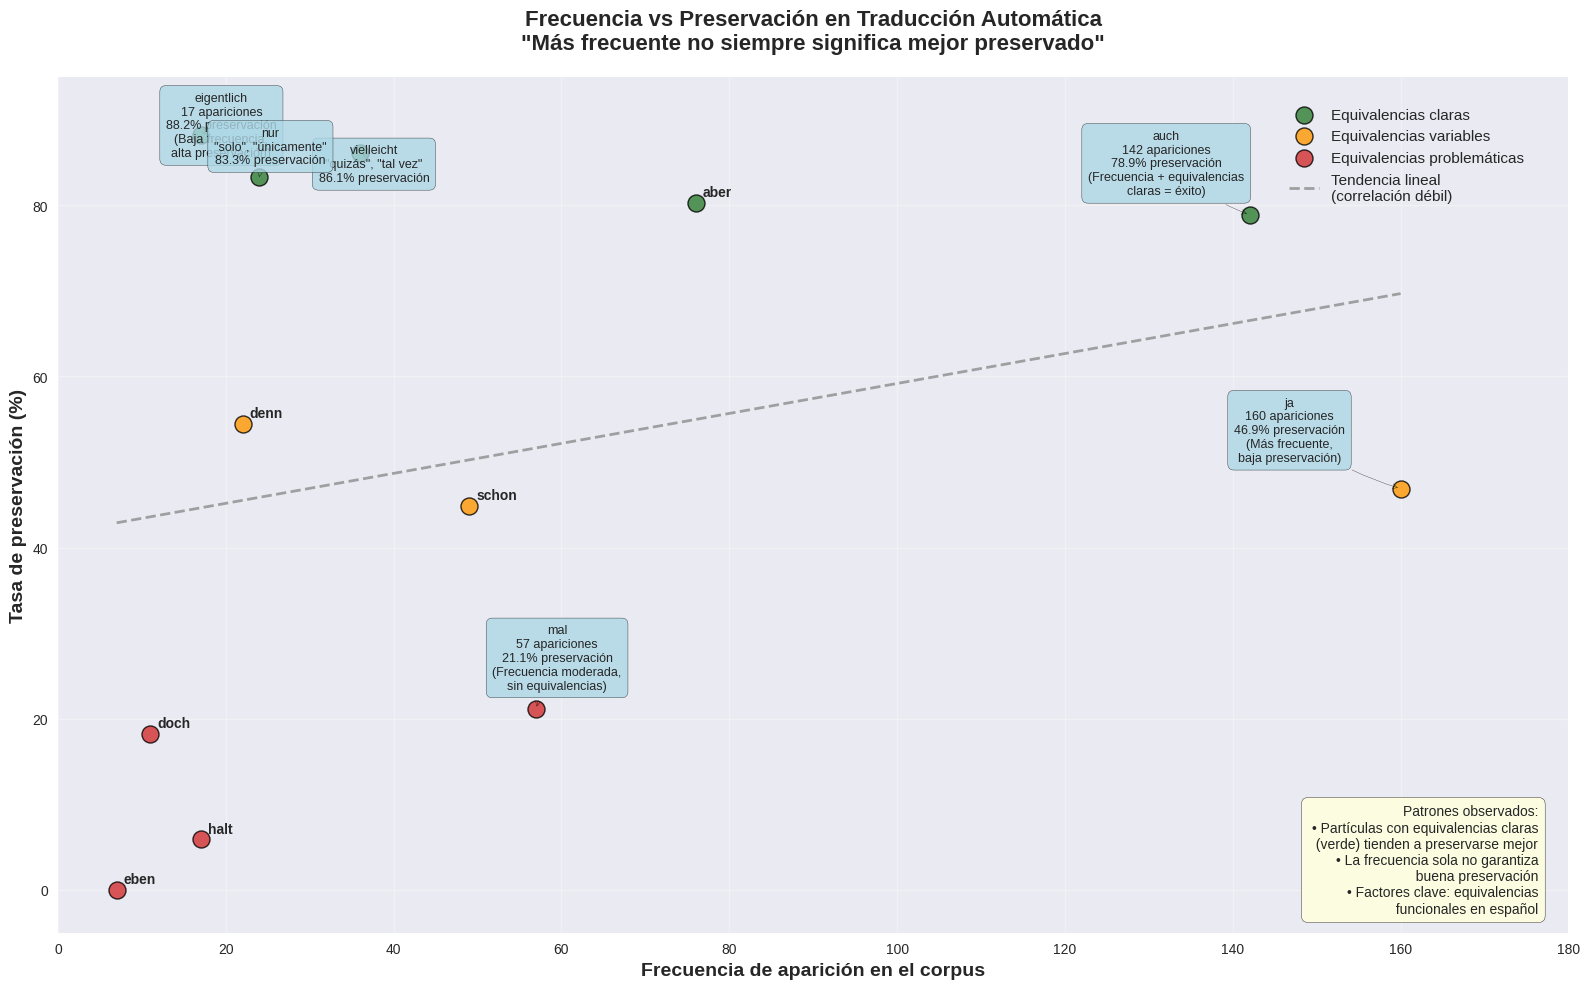

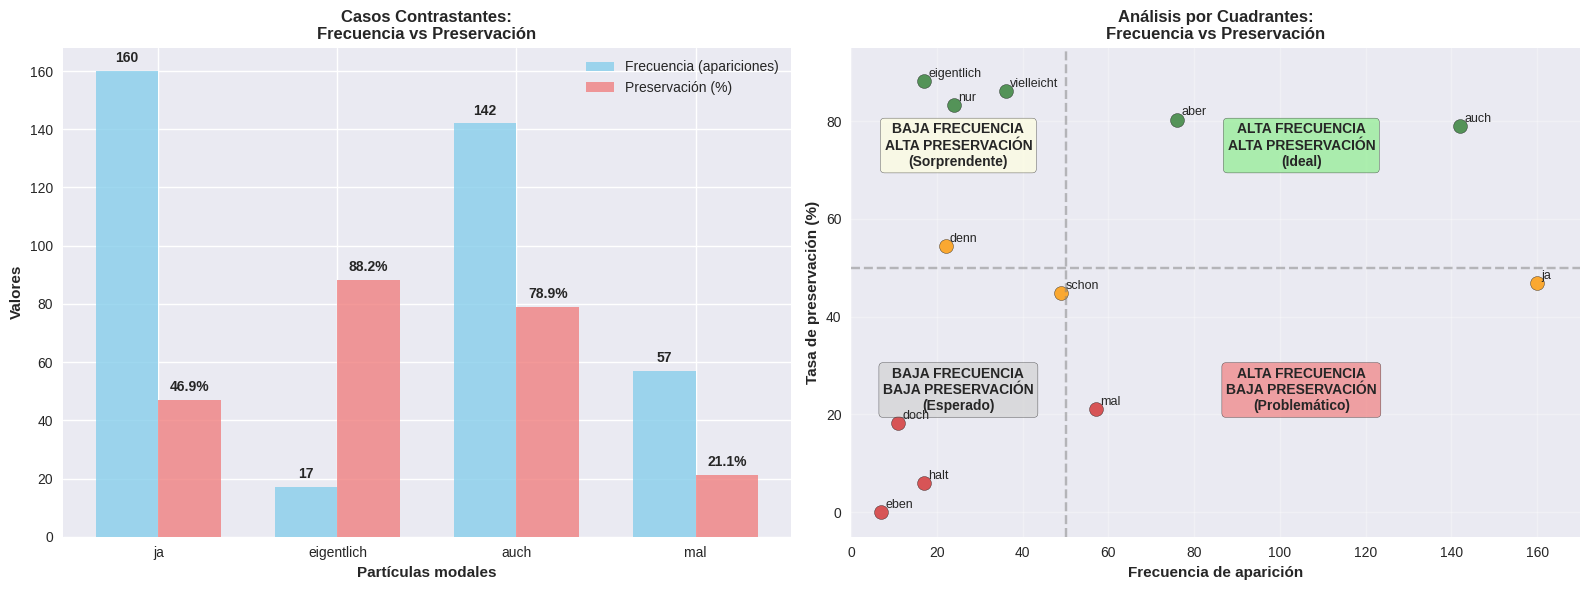

=== ANÁLISIS FRECUENCIA VS PRESERVACIÓN ===
Correlación lineal: 0.270

Casos destacados:
• Más frecuente: ja (160 apariciones) → 46.9% preservación
• Mejor preservada: eigentlich (88.2%) → 17 apariciones
• Peor preservada: eben (0.0%) → 7 apariciones


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos del experimento 2
datos = {
    'particula': ['ja', 'auch', 'aber', 'mal', 'schon', 'vielleicht',
                  'nur', 'denn', 'halt', 'eigentlich', 'doch', 'eben'],
    'apariciones': [160, 142, 76, 57, 49, 36, 24, 22, 17, 17, 11, 7],
    'tasa_preservacion': [46.9, 78.9, 80.3, 21.1, 44.9, 86.1, 83.3, 54.5, 5.9, 88.2, 18.2, 0.0],
    'equivalencias': ['variables', 'claras', 'claras', 'problemáticas', 'variables', 'claras',
                     'claras', 'variables', 'problemáticas', 'claras', 'problemáticas', 'problemáticas']
}

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(16, 10))

# Colores según tipo de equivalencias
colores = {
    'claras': '#2E7D32',        # Verde para equivalencias claras
    'variables': '#FF9800',     # Naranja para variables
    'problemáticas': '#D32F2F'  # Rojo para problemáticas
}

# Creación de una visualización tipo scatter plot con colores diferenciados
for equivalencia in ['claras', 'variables', 'problemáticas']:
    mask = [e == equivalencia for e in datos['equivalencias']]
    x_vals = [datos['apariciones'][i] for i, m in enumerate(mask) if m]
    y_vals = [datos['tasa_preservacion'][i] for i, m in enumerate(mask) if m]

    ax.scatter(x_vals, y_vals, c=colores[equivalencia],
               s=150, alpha=0.8, label=f'Equivalencias {equivalencia}',
               edgecolors='black', linewidth=1)

# Casos destacados mencionados en el texto
casos_destacados = {
    'ja': {'pos': (160, 46.9), 'texto': 'ja\n160 apariciones\n46.9% preservación\n(Más frecuente,\nbaja preservación)', 'offset': (-80, 20)},
    'eigentlich': {'pos': (17, 88.2), 'texto': 'eigentlich\n17 apariciones\n88.2% preservación\n(Baja frecuencia,\nalta preservación)', 'offset': (15, -15)},
    'auch': {'pos': (142, 78.9), 'texto': 'auch\n142 apariciones\n78.9% preservación\n(Frecuencia + equivalencias\nclaras = éxito)', 'offset': (-60, 15)},
    'mal': {'pos': (57, 21.1), 'texto': 'mal\n57 apariciones\n21.1% preservación\n(Frecuencia moderada,\nsin equivalencias)', 'offset': (15, 15)},
    'vielleicht': {'pos': (36, 86.1), 'texto': 'vielleicht\n"quizás", "tal vez"\n86.1% preservación', 'offset': (10, -20)},
    'nur': {'pos': (24, 83.3), 'texto': 'nur\n"solo", "únicamente"\n83.3% preservación', 'offset': (8, 10)}
}

# Añadir anotaciones para casos destacados
for particula, info in casos_destacados.items():
    ax.annotate(info['texto'],
                xy=info['pos'],
                xytext=info['offset'],
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1',
                               color='black', alpha=0.7),
                fontsize=9, ha='center')

# Añadir todas las etiquetas de partículas restantes
particulas_no_destacadas = set(datos['particula']) - set(casos_destacados.keys())
for particula in particulas_no_destacadas:
    idx = datos['particula'].index(particula)
    ax.annotate(particula,
                (datos['apariciones'][idx], datos['tasa_preservacion'][idx]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

# Línea de tendencia (opcional)
x_vals = datos['apariciones']
y_vals = datos['tasa_preservacion']
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
x_trend = np.linspace(min(x_vals), max(x_vals), 100)
ax.plot(x_trend, p(x_trend), "--", color='gray', alpha=0.7, linewidth=2,
        label=f'Tendencia lineal\n(correlación débil)')

# Personalizar ejes y título
ax.set_xlabel('Frecuencia de aparición en el corpus', fontsize=14, fontweight='bold')
ax.set_ylabel('Tasa de preservación (%)', fontsize=14, fontweight='bold')
ax.set_title('Frecuencia vs Preservación en Traducción Automática\n"Más frecuente no siempre significa mejor preservado"',
             fontsize=16, fontweight='bold', pad=20)

# Configurar límites y grid
ax.set_xlim(0, max(datos['apariciones']) + 20)
ax.set_ylim(-5, 95)
ax.grid(True, alpha=0.3)

# Leyenda
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=11)

# Añadir texto explicativo en esquina inferior derecha
texto_explicativo = ("Patrones observados:\n"
                    "• Partículas con equivalencias claras\n"
                    "  (verde) tienden a preservarse mejor\n"
                    "• La frecuencia sola no garantiza\n"
                    "  buena preservación\n"
                    "• Factores clave: equivalencias\n"
                    "  funcionales en español")

ax.text(0.98, 0.02, texto_explicativo,
        transform=ax.transAxes, fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9),
        verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.show()

# Creación de una segunda gráfica complementaria: matriz de correlación visual
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: Comparación directa de casos contrastantes
casos_contraste = ['ja', 'eigentlich', 'auch', 'mal']
x_pos = range(len(casos_contraste))
apariciones_contraste = [datos['apariciones'][datos['particula'].index(p)] for p in casos_contraste]
preservacion_contraste = [datos['tasa_preservacion'][datos['particula'].index(p)] for p in casos_contraste]

# Barras dobles para mostrar contraste
width = 0.35
bars1 = ax1.bar([x - width/2 for x in x_pos], apariciones_contraste, width,
                label='Frecuencia (apariciones)', color='skyblue', alpha=0.8)
bars2 = ax1.bar([x + width/2 for x in x_pos], preservacion_contraste, width,
                label='Preservación (%)', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Partículas modales', fontweight='bold')
ax1.set_ylabel('Valores', fontweight='bold')
ax1.set_title('Casos Contrastantes:\nFrecuencia vs Preservación', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(casos_contraste)
ax1.legend()

# Añadir valores en las barras
for bar, valor in zip(bars1, apariciones_contraste):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             str(valor), ha='center', va='bottom', fontweight='bold')
for bar, valor in zip(bars2, preservacion_contraste):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{valor}%', ha='center', va='bottom', fontweight='bold')

# Gráfica 2: Categorización por éxito/fracaso
ax2.set_xlim(0, max(datos['apariciones']) + 10)
ax2.set_ylim(-5, 95)

# Dividir en cuadrantes
ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=50, color='gray', linestyle='--', alpha=0.5)

# Etiquetas de cuadrantes
ax2.text(max(datos['apariciones'])/2 + 25, 75, 'ALTA FRECUENCIA\nALTA PRESERVACIÓN\n(Ideal)',
         ha='center', va='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
         fontweight='bold')
ax2.text(25, 75, 'BAJA FRECUENCIA\nALTA PRESERVACIÓN\n(Sorprendente)',
         ha='center', va='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7),
         fontweight='bold')
ax2.text(max(datos['apariciones'])/2 + 25, 25, 'ALTA FRECUENCIA\nBAJA PRESERVACIÓN\n(Problemático)',
         ha='center', va='center', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
         fontweight='bold')
ax2.text(25, 25, 'BAJA FRECUENCIA\nBAJA PRESERVACIÓN\n(Esperado)',
         ha='center', va='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7),
         fontweight='bold')

# Scatter plot en cuadrantes
for i, particula in enumerate(datos['particula']):
    color = colores[datos['equivalencias'][i]]
    ax2.scatter(datos['apariciones'][i], datos['tasa_preservacion'][i],
                c=color, s=100, alpha=0.8, edgecolors='black')
    ax2.annotate(particula, (datos['apariciones'][i], datos['tasa_preservacion'][i]),
                xytext=(3, 3), textcoords='offset points', fontsize=9)

ax2.set_xlabel('Frecuencia de aparición', fontweight='bold')
ax2.set_ylabel('Tasa de preservación (%)', fontweight='bold')
ax2.set_title('Análisis por Cuadrantes:\nFrecuencia vs Preservación', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Imprimir estadísticas relevantes
print("=== ANÁLISIS FRECUENCIA VS PRESERVACIÓN ===")
print(f"Correlación lineal: {np.corrcoef(datos['apariciones'], datos['tasa_preservacion'])[0,1]:.3f}")
print("\nCasos destacados:")
print(f"• Más frecuente: ja ({max(datos['apariciones'])} apariciones) → {datos['tasa_preservacion'][datos['apariciones'].index(max(datos['apariciones']))]}% preservación")
print(f"• Mejor preservada: eigentlich (88.2%) → {datos['apariciones'][datos['tasa_preservacion'].index(max(datos['tasa_preservacion']))]} apariciones")
print(f"• Peor preservada: eben (0.0%) → {datos['apariciones'][datos['tasa_preservacion'].index(min(datos['tasa_preservacion']))]} apariciones")